# Pandas dataframe accessor: Levi graph
## COO &rarr; matrix

**Keeping track:**
- Create Levi graph (hyper graph version) with Incidence structure
  - Incidence matrix, simple graph, edges sum to 2 --> this is always **sparse**
- ~~Bipartite structure: matrix with entity on one index and connections on another index~~
- Tidy graph: edgelist and edge metadata graph
- Make sure pandas categorical works with ints
  - in nb, ss example has index as ints, not categoricals
  - pandas_categoricals
- Levi pandas accessor:
  - accessor to series, checks for multiindex categorical (this is the input)
  - instead of pandas.sparse
  - can control results to work with networkx etc
- Grabble object: built out of data classes 

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
import beartype as bt

### Create data to use in development:
- Token Co-occurrence matrix
- Document-term matrix (this is an example of a bipartite structure/incidence matrix)
- COO (format: multi-index pandas Series)


In [2]:
# Create sample dataset

doc_ids = [str(x) for x in range(5)]
texts = [
    "the quick brown fox jumped",
    "the fox jumped",
    "the dog jumped",
    "one brown fox",
    "ten brown dogs",
   ]

df = pd.DataFrame({'doc_id': doc_ids,
                    'text':texts,
                    })

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=['the'])
cv.fit(df['text'])
tokens = cv.get_feature_names_out()  #alphabetical

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Create cooccurence matrix

results = cv.transform(df['text'])
coocc = results.T.dot(results)
# np.fill_diagonal(coocc.values, 0)
coocc = pd.DataFrame(results.T.dot(results).toarray(), index=tokens, columns=tokens)
np.fill_diagonal(coocc.values, 0)
coocc

,brown,dog,dogs,fox,jumped,one,quick,ten
brown,0,0,1,2,1,1,1,1
dog,0,0,0,0,1,0,0,0
dogs,1,0,0,0,0,0,0,1
fox,2,0,0,0,2,1,1,0
jumped,1,1,0,2,0,0,1,0
one,1,0,0,1,0,0,0,0
quick,1,0,0,1,1,0,0,0
ten,1,0,1,0,0,0,0,0


In [ ]:
# Create document term matrix (BIPARTITE STRUCTURE)

results = cv.transform(df['text'])
features = cv.get_feature_names_out()
doc_term = pd.DataFrame(results.toarray(), columns=features)
doc_term = doc_term.reindex(columns=doc_term.columns.tolist()+['cat', 'bear', 'tree'], fill_value=0)
doc_term

,brown,dog,dogs,fox,jumped,one,quick,ten,cat,bear,tree
0,1,0,0,1,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,1,0,0,0


In [ ]:
# Create COO Series
# using scipy sparse module here, but we want to avoid it in production
coo_matrix = sparse.coo_matrix(doc_term.values)
coo_rows = coo_matrix.row
coo_cols = coo_matrix.col
coo_vals = coo_matrix.data

term_dict = dict(zip(range(0,11), doc_term.columns))
term_dict

{0: 'brown',
 1: 'dog',
 2: 'dogs',
 3: 'fox',
 4: 'jumped',
 5: 'one',
 6: 'quick',
 7: 'ten',
 8: 'cat',
 9: 'bear',
 10: 'tree'}

In [ ]:
coo_cols = coo_cols.tolist()
coo_col_names = [term_dict[key] for key in coo_cols]

In [ ]:
idx=pd.MultiIndex.from_arrays([coo_matrix.row, coo_col_names])
coo = pd.DataFrame(coo_matrix.data, index=idx, columns=["flag"])
coo

flag
0 brown      1
  fox        1
  jumped     1
  quick      1
1 fox        1
  jumped     1
2 dog        1
  jumped     1
3 brown      1
  fox        1
  one        1
4 brown      1
  dogs       1
  ten        1

In [ ]:
print(coo_matrix)

  (0, 0)	1
  (0, 3)	1
  (0, 4)	1
  (0, 6)	1
  (1, 3)	1
  (1, 4)	1
  (2, 1)	1
  (2, 4)	1
  (3, 0)	1
  (3, 3)	1
  (3, 5)	1
  (4, 0)	1
  (4, 2)	1
  (4, 7)	1


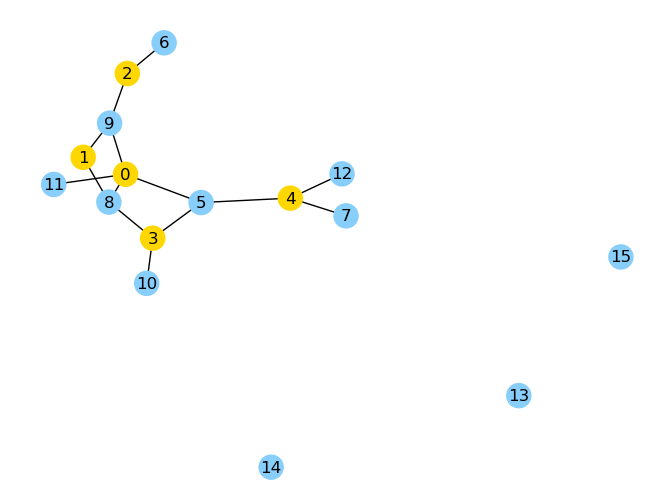

In [ ]:
graph = nx.algorithms.bipartite.from_biadjacency_matrix(coo_matrix)
sets = nx.get_node_attributes(graph, name="bipartite")
colors = {0: 'gold', 1: 'lightskyblue'}

nx.draw(graph, with_labels=True, node_color=[colors[node[1]['bipartite']] 
                    for node in graph.nodes(data=True)])


In [ ]:
graph.edges()

EdgeView([(0, 5), (0, 8), (0, 9), (0, 11), (1, 8), (1, 9), (2, 6), (2, 9), (3, 5), (3, 8), (3, 10), (4, 5), (4, 7), (4, 12)])

In [ ]:
# tuple_list = list(zip(coo_rows, coo_col_names, coo_matrix.data))
tuple_list = list(zip(coo_rows, coo_col_names, ))

In [ ]:
tuple_list

[(0, 'brown'),
 (0, 'fox'),
 (0, 'jumped'),
 (0, 'quick'),
 (1, 'fox'),
 (1, 'jumped'),
 (2, 'dog'),
 (2, 'jumped'),
 (3, 'brown'),
 (3, 'fox'),
 (3, 'one'),
 (4, 'brown'),
 (4, 'dogs'),
 (4, 'ten')]

In [ ]:
array_x = nx.algorithms.bipartite.biadjacency_matrix(graph, row_order=tuple_list)
array_x

NameError: name 'nx' is not defined

In [ ]:
print(graph)

In [ ]:
# Make sure pandas categorical works with ints
#   - in nb, ss example has index as ints, not categoricals
#   - pandas_categoricals

In [ ]:
from phantom import Phantom
from phantom.predicates import Predicate
import beartype.typing as bt
from beartype.door import is_bearable


In [ ]:
def of_beartype(t: bt.Union[type, bt.Tuple[type, ...]]) -> Predicate[object]:
    """ From `phantom.predicates.generic.of_type`

    Create a new predicate that succeeds when its argument is bearable on ``t``.
    """

    def check(a: object) -> bool:
        return is_bearable(a, t)

    return check

In [ ]:
# chck = of_beartype(coo)
# chck(coo)

In [ ]:
coo.unstack(level=1, )

In [4]:
@pd.api.extensions.register_dataframe_accessor("levi")   #can also be df, series, or index
class LeviAccessor:
    def __init__(self, pandas_obj):
        self._validate(pandas_obj)
        self._obj = pandas_obj

    @staticmethod
    def _validate(obj):
        # TODO: use beartype
        # verify there is a column latitude and a column longitude
        if len(obj.columns) > 1:
            raise AttributeError("Must have single column of flags")  #fixme: this is just filler to get accesor to run, need to update
    #     if "latitude" not in obj.columns or "longitude" not in obj.columns:
    #         raise AttributeError("Must have 'latitude' and 'longitude'.")

    @property
    def test_attr(self):        
        return self._obj.iloc[0]
    
    @property
    def incidence_matrix(self):
        return self._obj.unstack(level=1, fill_value=0)
    

    # def testing(self):
    #     # plot this array's data on a map, e.g., using Cartopy
    #     print(self.__str__)
    #     pass

In [5]:
coo.levi.test_attr

NameError: name 'coo' is not defined

In [ ]:
coo.levi.incidence_matrix

flag                                  
  brown dog dogs fox jumped one quick ten
0     1   0    0   1      1   0     1   0
1     0   0    0   1      1   0     0   0
2     0   1    0   0      1   0     0   0
3     1   0    0   1      0   1     0   0
4     1   0    1   0      0   0     0   1